### Book Recommendation system using K-nearest Neighbour

---

#### Read Data set with necessary features

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1", warn_bad_lines=False)
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'ImageUrIS', 'ImageUrIM', 'imageUrIL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1", warn_bad_lines=False)
users.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1", warn_bad_lines=False)
rating.columns = ['userID', 'ISBN', 'bookRating']

In [12]:
print(rating.shape)
print(list(rating.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


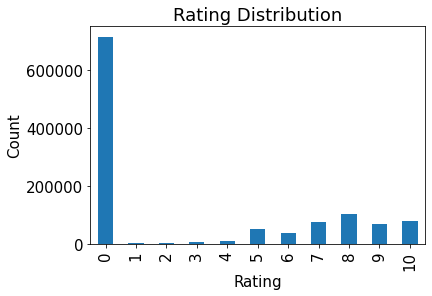

In [13]:
plt.rc("font", size = 15)
rating.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('System1.png', bbox_inches='tight')
plt.show()

In [14]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'ImageUrIS', 'ImageUrIM', 'imageUrIL']


In [15]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


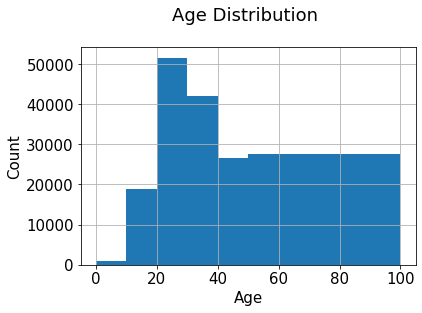

In [16]:
users.Age.hist(bins=[0,10,20,30,40,50,100])
plt.title('Age Distribution \n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

Observations: In this data set, the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

##### To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [19]:

counts1 = rating['userID'].value_counts()
rating = rating[rating['userID'].isin(counts1[counts1 >= 200].index)]
counts = rating['bookRating'].value_counts()
rating = rating[rating['bookRating'].isin(counts[counts >= 100].index)]

### Collaborative Filtering Using K-Nearest  Neighbours KNN

KNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top k nearest neighbours, for example, we first present rating in a matrix with the matrix having one row for each item(book) and one column for each user

In [26]:
combine_book_rating = pd.merge(rating, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'ImageUrIS','ImageUrIM','imageUrIL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head(10)

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
6,24194,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
7,25981,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
8,26535,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
9,28204,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


We Then group by book titles and create a new column for total rating count

In [29]:
combine_book_rating = combine_book_rating.dropna(axis=0, subset =['bookTitle'])
book_rating_count  =(combine_book_rating.
                    groupby(by = ['bookTitle'])['bookRating'].
                    count().
                    reset_index().
                    rename(columns = {'bookRating' : 'totalRatingCount'})
                    [['bookTitle', 'totalRatingCount']]
                    )
book_rating_count.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


We Combine the rating data with the total rating count data, this gives you exactly what we need to find out which books are popular and filter out lesser-known books

In [30]:
rating_with_total_rating_count = combine_book_rating.merge(book_rating_count, left_on = 'bookTitle', right_on = 'bookTitle', how='left')
rating_with_total_rating_count.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [32]:
populatity_threshold = 50
rating_popular_book = rating_with_total_rating_count.query('totalRatingCount >= @populatity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [34]:
rating_popular_book.shape


(62149, 5)

### Filter User from US And Canada Only

In [42]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how='left')
us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"mechanicsville, maryland, usa"


### Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros(since we will calculate distances between rating vectors). We Then transform the values(rating) of the matrix dataframe into a spicy sparse matrix for more efficient calculations

Finding the nearest neighbours we used unsupervised algorithms with sklearn neighours. The algorithm we use to compute the nearest neighbours is brute and we specify metric=cosine so the algorithm will calculate the cosine similarity between rating vectors. Finally we fit the model.

In [43]:

from scipy.sparse import csr_matrix

us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [46]:
us_canada_user_rating_pivot.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,271448,271705,273979,274061,274308,274808,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


In [56]:
us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [53]:

query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)


79


In [57]:
us_canada_user_rating_pivot.index[query_index]

'Birthright'

In [58]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Birthright:

1: Key of Knowledge (Key Trilogy (Paperback)), with distance of 0.4683077423249007:
2: Midnight Bayou, with distance of 0.49230482294724887:
3: Sacred Sins, with distance of 0.5154192527331174:
4: Key of Light (Key Trilogy (Paperback)), with distance of 0.5190809172908036:
5: Three Fates, with distance of 0.534042888913298:
